# Notebook to perform local ID estimation

## Import

In [15]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from tqdm import tqdm


import importlib
import functions_IDEAS  
importlib.reload(functions_IDEAS)  
from functions_IDEAS import compute_ID

## functions

In [16]:
def add_local_ID_to_adata(Adata, ID_dataframe, N_neigh=0):

    if N_neigh==0 : 
        N_neigh = 0.1 * len(Adata)

    if f'local_ID_{N_neigh}' not in Adata.obs.columns:
        Adata.obs[f'local_ID_{N_neigh}'] = pd.NA 

    index = [item[0] for item in ID_dataframe.index]
    for barcode,id_val in zip(index, ID_dataframe.ID.values):
        Adata.obs.loc[Adata.obs_names == barcode, f'local_ID_{N_neigh}'] = id_val

    Adata.obs[f'local_ID_{N_neigh}'] = Adata.obs[f'local_ID_{N_neigh}'].replace({pd.NA: np.nan}).astype(float)

    return Adata

In [17]:
def create_layer_df(adata, n_neighbors):
    layers = ['inner', 'outer']
    data = [(adata[adata.obs.layer == layer].obs[f'local_ID_{n_neighbors}'].values, layer) for layer in layers]
    return pd.DataFrame({
        'Value': [val for values, _ in data for val in values],
        'Layer': [layer for values, layer in data for _ in values]
    })

## First dataset (Tran et al.)

In [6]:
# upload raw data 
adata_fbs=sc.read('../Datasets/FBS_IDEAS.h5ad')
adata_a2s=sc.read('../Datasets/A2S_IDEAS.h5ad')

### FBS

In [12]:
# compute local ID for each cell
n_neighbors = 600
IDs_fbs = compute_ID(adata_fbs, method='local_2nn', n_neighbors = n_neighbors, id_score = True)
adata_fbs = add_local_ID_to_adata(adata_fbs, IDs_fbs, n_neighbors)


Computing ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [00:44<00:00, 44.81s/it]


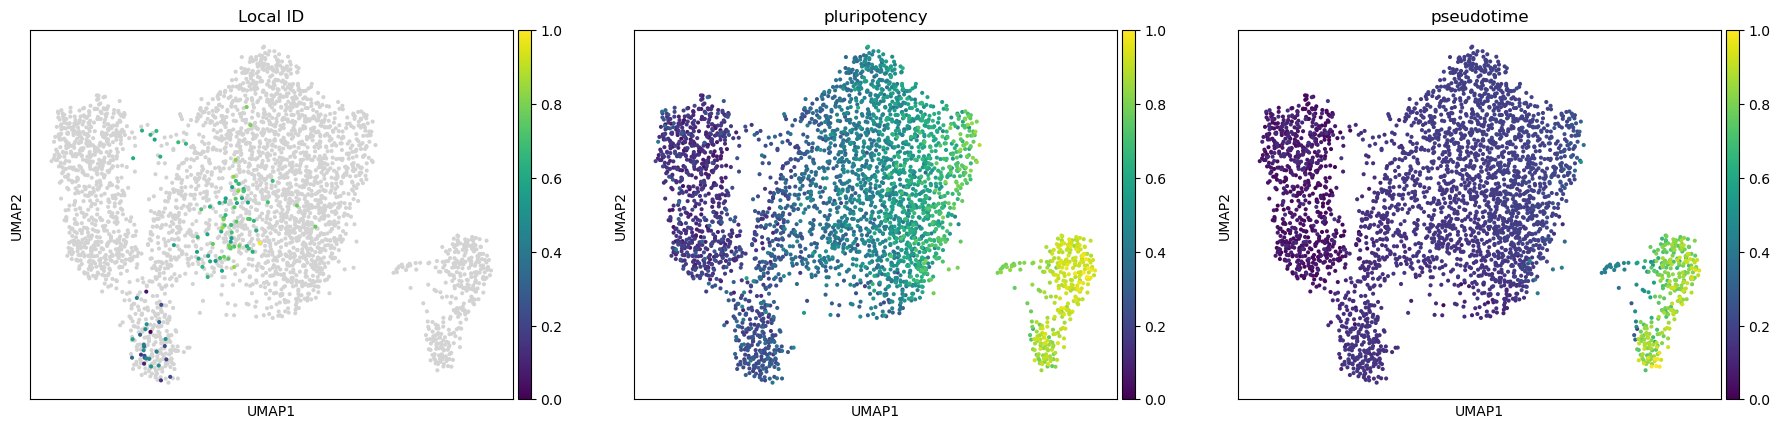

In [13]:
#visualize Local ID, pluripotency and pseudotime in a UMAP projection
sc.pl.umap(adata_fbs, color=[f'local_ID_{n_neighbors}', 'pluripotency', 'dpt_pseudotime'], title = ['Local ID', 'pluripotency', 'pseudotime'], color_map = 'viridis', alpha=1.)

In [18]:
# save results to plot figure 5 

#adata_fbs.write('../Datasets/FBS_to_plot.h5ad')

### A2S

In [23]:
# compute local ID for each cell
n_neighbors = 600
IDs_a2s = compute_ID(adata_a2s, method='local_2nn', n_neighbors = n_neighbors, id_score = True)
adata_a2s = add_local_ID_to_adata(adata_a2s, IDs_a2s, n_neighbors)

Computing ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [39:35<00:00, 2375.67s/it]


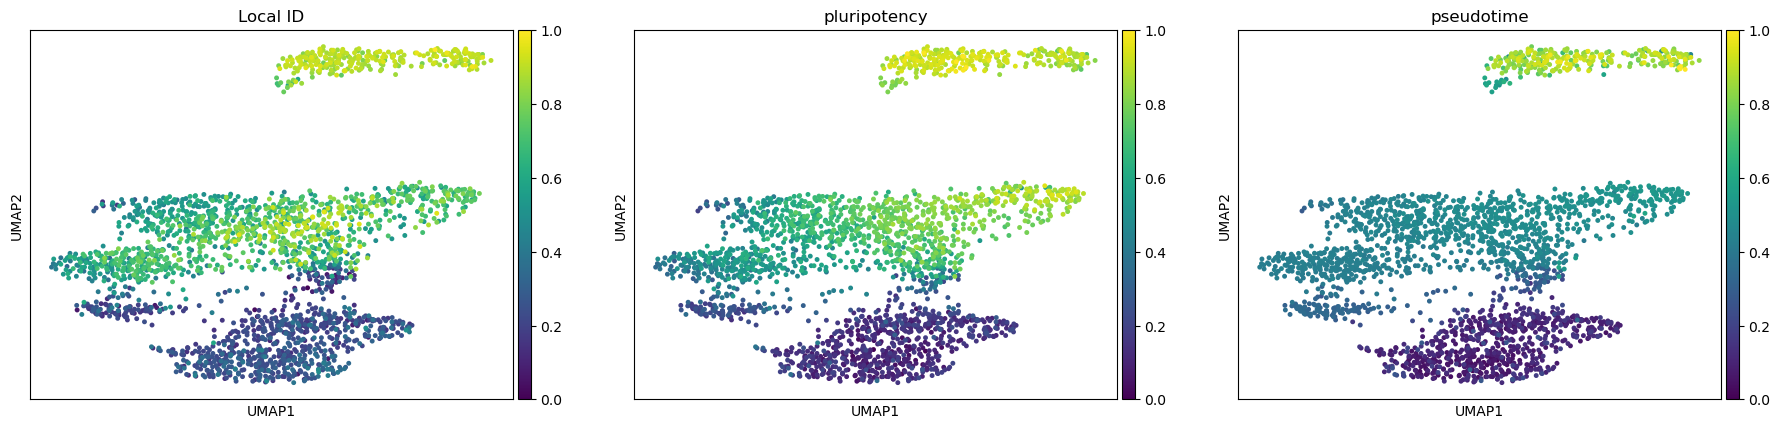

In [24]:
#visualize Local ID, pluripotency and pseudotime in a UMAP projection
sc.pl.umap(adata_a2s, color=[f'local_ID_{n_neighbors}', 'pluripotency', 'dpt_pseudotime'], title = ['Local ID', 'pluripotency', 'pseudotime'], color_map = 'viridis', alpha=1.)

In [26]:
# save results to plot figure 5 

#adata_a2s.write('../Datasets/A2S_to_plot.h5ad')

## Xenopus dataset

In [18]:
adata_xen = sc.read('../Datasets/xenopus_correct.h5ad')

In [19]:
adata_xen

AnnData object with n_obs × n_vars = 3364 × 31179
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'isnt', 'integrated_snn_res.0.5', 'seurat_clusters'
    var: 'features'
    uns: 'isnt_colors', 'seurat_clusters_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/maddalenastaiano/opt/anaconda3/envs/pancreas/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


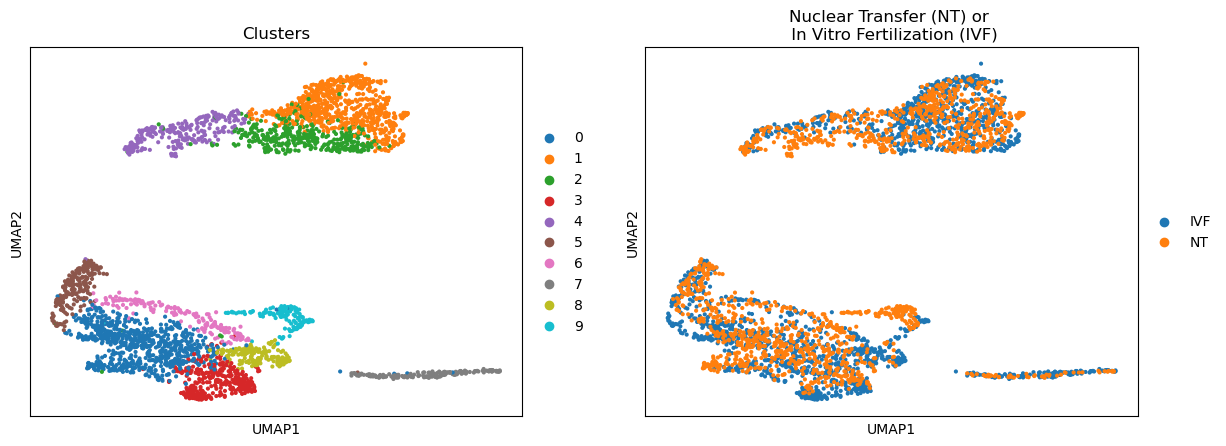

In [20]:
# visualize cluster division and nuclear transfer (NT) vs in vitro fertilization (IVF)
sc.pl.umap(adata_xen, color=['seurat_clusters', 'isnt'], title = ['Clusters', 'Nuclear Transfer (NT) or \n In Vitro Fertilization (IVF)'], alpha=1.)

In [21]:
#Select the experiment with a higher number of cells

df = pd.DataFrame({'batch': adata_xen.obs.stim, 'condition': adata_xen.obs.isnt})
contingency_table = pd.crosstab(df['batch'], df['condition'])
print(contingency_table)

adata_ivf = adata_xen[adata_xen.obs.stim == 'SIGAH5']  #'IVF'
adata_nt = adata_xen[adata_xen.obs.stim == 'SIGAH12']  #'NT'

condition   IVF    NT
batch                
SIGAA2      559     0
SIGAB2        0   495
SIGAH5     1267     0
SIGAH12       0  1043


In [22]:
# run local ID analysis separately for NT and IVF
n_neighbors = 100
IDs_ivf = compute_ID(adata_ivf, method='local_2nn', n_neighbors = n_neighbors)
IDs_nt = compute_ID(adata_nt, method='local_2nn', n_neighbors = n_neighbors)
adata_ivf = add_local_ID_to_adata(adata_ivf,IDs_ivf, n_neighbors)
adata_nt = add_local_ID_to_adata(adata_nt,IDs_nt, n_neighbors)

Computing ID:


Computing Intrinsic Dimension:   0%|          | 0/1 [00:00<?, ?it/s]

Computing ID:


Computing Intrinsic Dimension: 100%|██████████| 1/1 [00:33<00:00, 33.22s/it]
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_56839/2734031154.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs[f'local_ID_{N_neigh}'] = pd.NA
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_56839/2734031154.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Adata.obs[f'local_ID_{N_neigh}'] = pd.NA


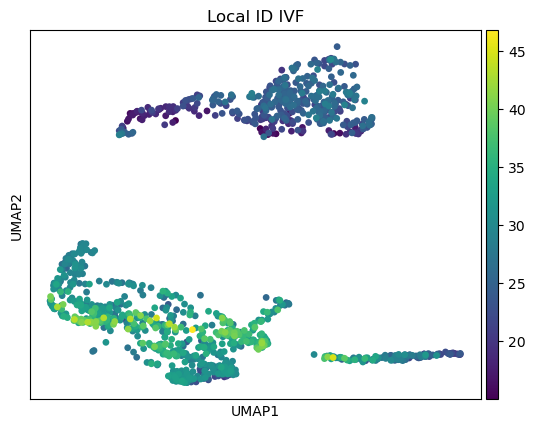

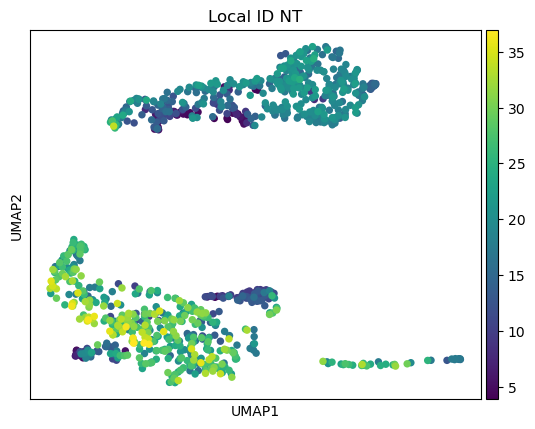

In [26]:
# visualize local ID in a UMAP projection
sc.pl.umap(adata_ivf, color=['local_ID_100'], title = ['Local ID IVF'], alpha=1.)
sc.pl.umap(adata_nt, color=['local_ID_100'], title = ['Local ID NT'], alpha=1.)

In [35]:
#save results to plot figure 5

#adata_ivf.write('../Datasets/Xenopus_IVF_to_plot.h5ad')
#adata_nt.write('../Datasets/Xenopus_NT_to_plot.h5ad')